In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import vgg16
from torchvision import transforms
import torch.optim as optim
from PIL import ImageEnhance

In [2]:
dataset = torchvision.datasets.ImageFolder('C:\\Users\\Lenovo\\Documents\\Data science\\images',
                                           transform = transforms.Compose([transforms.CenterCrop(224),
                                                                          transforms.ToTensor(),
#                                                                           transforms.Normalize(
#                                                                             mean=[0.485, 0.456, 0.406],
#                                                                             std=[0.229, 0.224, 0.225])
                                                                          ]))

dataloader = torch.utils.data.DataLoader(dataset,1)

In [3]:
data,_ = next(iter(dataloader))

In [4]:
image = transforms.ToPILImage()(data[0]).convert("RGB")

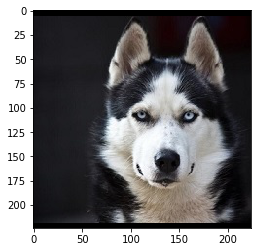

In [5]:
plt.imshow(image)

In [6]:
pred = vgg16(pretrained=True)
qq = pred(data)

In [7]:
qq.argmax()

tensor(248)

## 365: 'orangutan, orang, orangutang, Pongo pygmaeus',

In [8]:
class Vgg16(nn.Module):
    def __init__(self):
        super().__init__()
        self.modules_no = [0,2,5,7,10,12,14,17,19,21,24,26,28]
        self.features = vgg16(pretrained=True).features
        self.features[4]  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[9]  = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[16] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[23] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        self.features[30] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False,return_indices = True)
        
        self.avgpool = vgg16(pretrained=True).avgpool
        self.classifier = vgg16(pretrained=True).classifier
                
        
    def forward(self,x):
        results = {}
        maxpool_indices = {}
        for index,layer in enumerate(self.features):
            if index in [4,9,16,23,30]:
                x,i = layer(x)
                maxpool_indices[index] = i
                
            else :
                x = layer(x)
            
            if index in self.modules_no:
                results[index] = x    
                
        return results,maxpool_indices
    

In [9]:
model = Vgg16()
model = model.cuda()
data = data.cuda()


In [10]:
with torch.no_grad():
    out,maxpool_ind = model(data)

In [11]:
out_cpu = {}
for i in out:
    out_cpu[i]=out[i].cpu()



# model = model.cpu()
# data = data.cpu()

# del out,maxpool_ind

In [17]:
out_cpu[0].size()

torch.Size([1, 64, 224, 224])

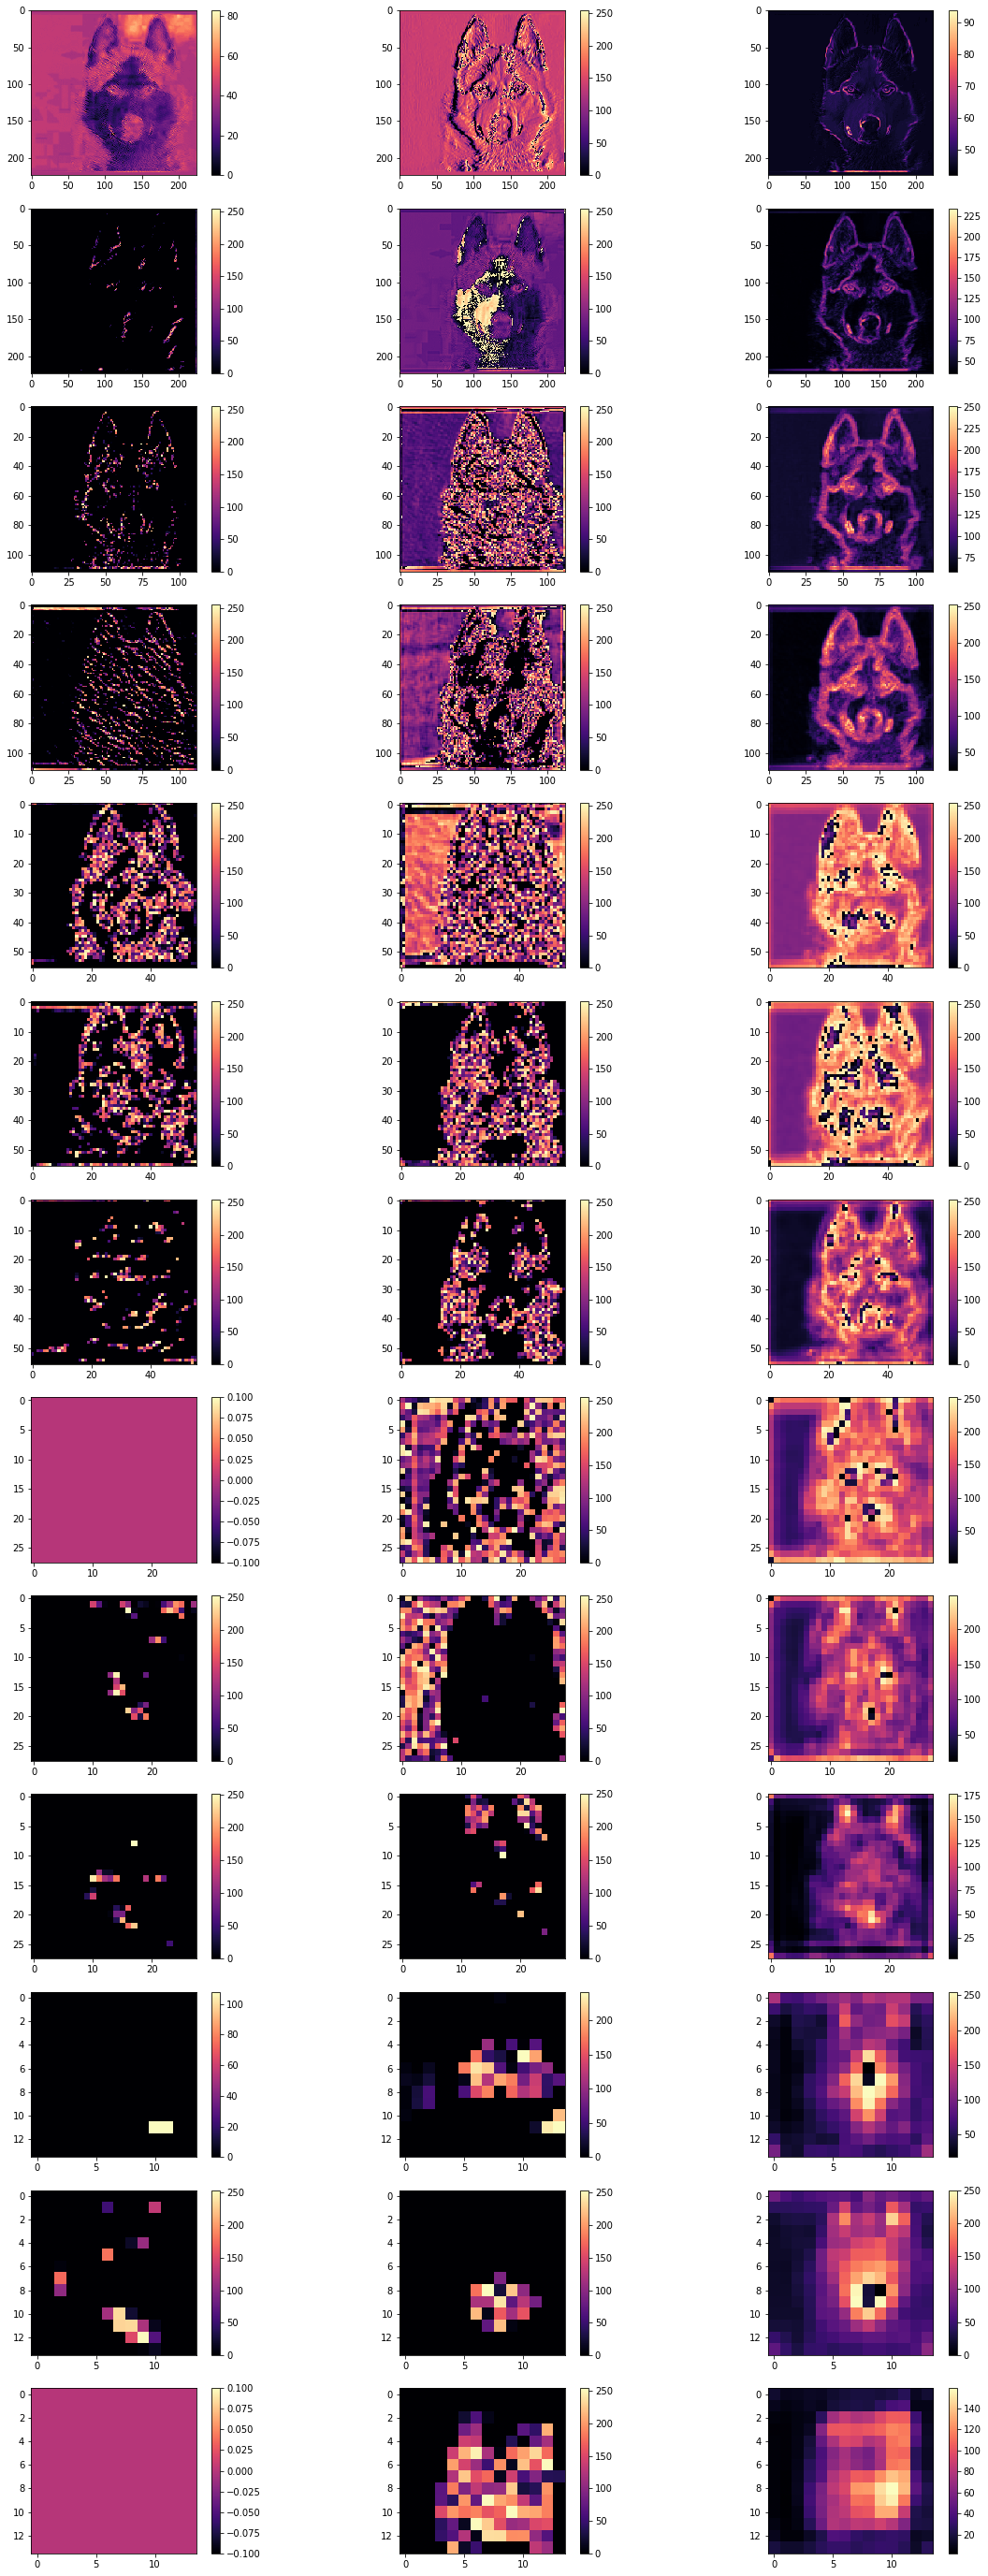

In [22]:
ind = 1
plt.figure(figsize=[20,50])
for layer in out_cpu:
#   SELECTING A RANDOM ACTIVATION MAP
    filter_random = out_cpu[layer][0][np.random.randint(0,np.shape(out_cpu[layer])[1])]
    plot_loc = plt.subplot(13,3,ind)
    ind += 1
    vis = transforms.ToPILImage()(filter_random)
    plt.imshow(vis,cmap='magma')
    plt.colorbar()
    
#   SELECTING MAX ACTIVATION MAP
    filter_max = out_cpu[layer][0][0]
    max_norm = filter_max.norm()
    for filters in out_cpu[layer][0][1:]:
        if filters.norm() > max_norm :
            max_norm = filters.norm()
            filter_max = filters
    vis_mean = transforms.ToPILImage()(filter_max)
    plot_loc = plt.subplot(13,3,ind)
    ind += 1    
    plt.imshow(vis_mean,cmap='magma')
    plt.colorbar()
    
#     CALCULATING MEAN OF ALL ACTIVATION MAPS IN THE LAYER
    mean = torch.zeros(np.shape(out_cpu[layer])[2],np.shape(out_cpu[layer])[3])
    for i in out_cpu[layer][0]:
        mean += i
    vis_mean = transforms.ToPILImage()(mean/np.shape(out_cpu[layer])[1])
    plot_loc = plt.subplot(13,3,ind)
    
    ind += 1    
    plt.imshow(vis_mean,cmap='magma')
    plt.colorbar()

In [23]:
class Vgg16_deconv(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.module_list = nn.ModuleList([
                           nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512,512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512,512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(256,256,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(256,256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(128, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.MaxUnpool2d(kernel_size=2,stride=2),
                            nn.ReLU(),
                            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.ReLU(),
                            nn.ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                            ])
        
        self.first_layer = nn.ModuleDict({
                            '2'  : nn.ConvTranspose2d(1,512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '4'  : nn.ConvTranspose2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '6'  : nn.ConvTranspose2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '9'  : nn.ConvTranspose2d(1,512,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '11' : nn.ConvTranspose2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '13' : nn.ConvTranspose2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '16' : nn.ConvTranspose2d(1,256,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '18' : nn.ConvTranspose2d(1,256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '20' : nn.ConvTranspose2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '23' : nn.ConvTranspose2d(1, 128,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '25' : nn.ConvTranspose2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '28' : nn.ConvTranspose2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            '30' : nn.ConvTranspose2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                            })
        
        
        self.conv2deconv_idx = {0:30 ,2:28 ,5:25 ,7:23 ,10:20 ,12:18 ,14:16 ,17:13 ,19:11 ,21:9 ,24:6 ,26:4 ,28:2 }
    #         deconv starts with maxpool and relu outputs

        self.unpool2pool_idx = {26:4 ,21:9 ,14:16 ,7:23 ,0:30 }
        self.deconv2conv_bias = {2:26 ,4:24 ,6:21 ,9:19 ,11:17 ,13:14 ,16:12 ,18:10 ,20:7 ,23:5 ,25:2 ,28:0 }
            
        self.initialize_weights()
               
        
    def initialize_weights(self):
        for i,f in enumerate(self.module_list):
            if isinstance(f,nn.ConvTranspose2d):
                f.weight.data = vgg16(pretrained = True).features[-i-1].weight.data.cuda()            
                if i!=30:
                    f.bias.data = vgg16(pretrained = True).features[self.deconv2conv_bias[i]].bias.data
        
        
    def forward(self,x,layer_idx,map_idx,maxpool_indices):
        inp = x[layer_idx][0][map_idx].unsqueeze(0).unsqueeze(0)
        current_layer_idx = self.conv2deconv_idx[layer_idx]
        
        self.first_layer[str(current_layer_idx)].weight.data = vgg16(pretrained=True).features[layer_idx].weight[map_idx].data.unsqueeze(0).permute(0,1,3,2).cuda()
        inp = self.first_layer[str(current_layer_idx)](inp)
        current_layer_idx +=1
        
        for f in self.module_list[current_layer_idx : ]:
#             print(f)
#             print(inp.size())
            if isinstance(f,nn.MaxUnpool2d):
#                 print(maxpool_indices[self.unpool2pool_idx[current_layer_idx]].size())
                inp = f(inp,maxpool_indices[self.unpool2pool_idx[current_layer_idx]])
            else :
                inp = f(inp)
            current_layer_idx += 1
            
        return inp
        
                        
                    
            

In [24]:
deconvnet = Vgg16_deconv().cuda()

0 	 58
2 	 40
5 	 61
7 	 6
10 	 75
12 	 138
14 	 109
17 	 192
19 	 166
21 	 330
24 	 246
26 	 262
28 	 151


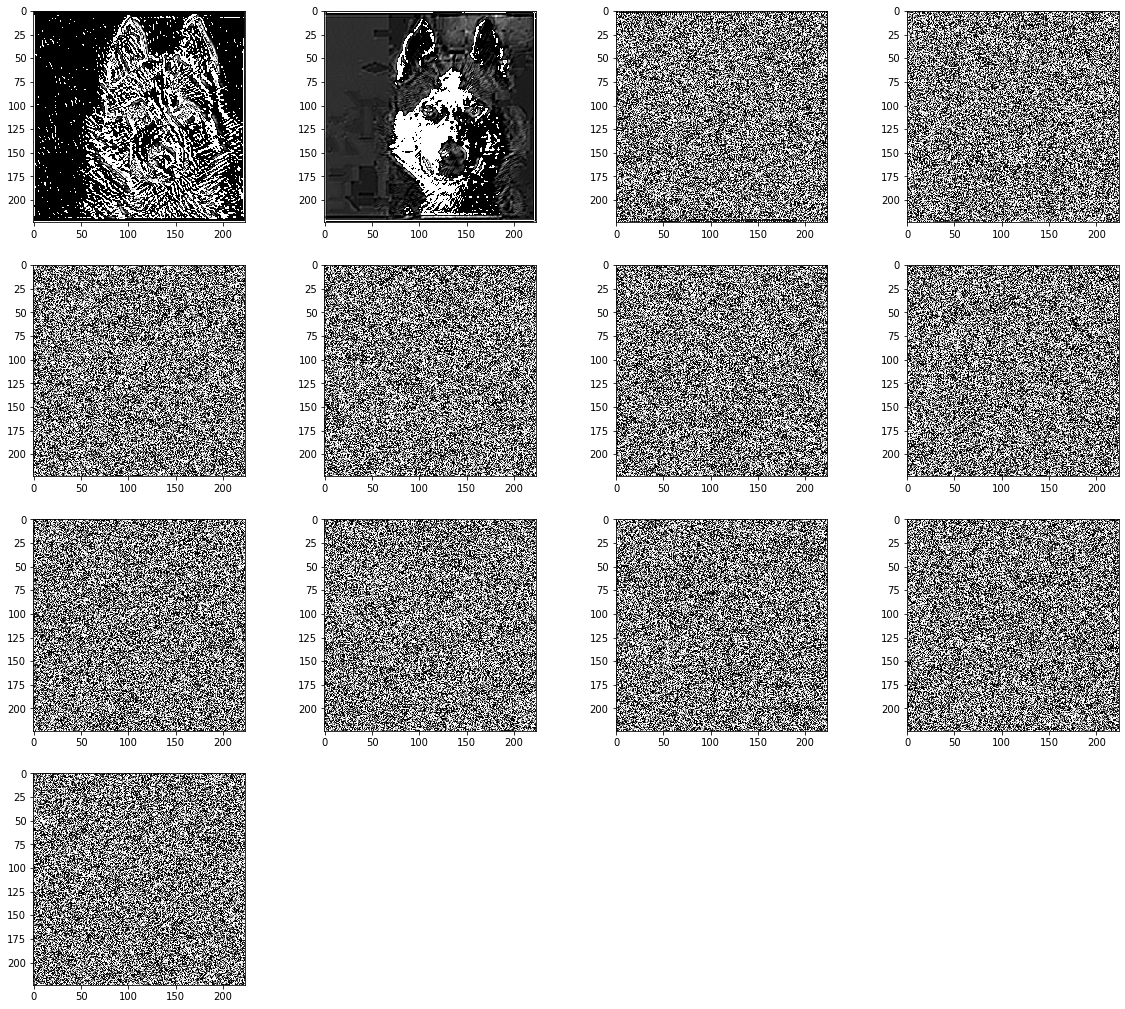

In [34]:
ind = 1
plt.figure(figsize=[20,60])
for j in [0,2,5,7,10,12,14,17,19,21,24,26,28]:
        filter_max = out[j][0][0]
        max_norm = filter_max.norm()
        indexx = 1
        for i,filters in enumerate(out[j][0][1:]):
            if filters.norm() > max_norm :
                indexx = i+1
                max_norm = filters.norm()
                filter_max = filters
        print(j,"\t",indexx)
        
        with torch.no_grad():
            deconv_output = deconvnet(out ,j ,indexx ,maxpool_ind)
            
        deconv_output = deconv_output.cpu()
        vis_mean = transforms.ToPILImage()(deconv_output[0][0]).convert("RGB")
        enhancer = ImageEnhance.Contrast(vis_mean)
        factor = 2
        enh_vis_mean = enhancer.enhance(factor)
        plot_loc = plt.subplot(13,4,ind)
        ind += 1    
        plt.imshow(enh_vis_mean)